# ICU Occupancy Forecast with Prophet (COVID-19, Italy)

In [1]:
#!pip install prophet
#!pip install scikit-learn

## Set - up

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Parameters

In [24]:
URL_DATA   = ("https://raw.githubusercontent.com/pcm-dpc/COVID-19/"
              "master/dati-regioni/dpc-covid19-ita-regioni.csv")

USE_REGION = True                       # False ➜ aggregate Italy
REGIONE    = "Lombardia"                # used only if USE_REGION = True
POSTI_TI   = 1200                       # ICU bed capacity for the region
HORIZON    = 120                         # forecast horizon (days)

LAG_POS    = 14#11#12#11#18#10                         # days between positives ➜ ICU stock
LAG_ING    = 8#6#9#7                          # days between ICU admissions ➜ stock
ROLL_WIN   = 3                          # rolling median window for smoothing

## Data

In [4]:
df = pd.read_csv(URL_DATA, parse_dates=["data"]).sort_values("data")

if USE_REGION:
    df = df.query("denominazione_regione == @REGIONE").copy()
else:                                   # aggregate over Italy
    df = (df.groupby("data", as_index=False)
            .agg({"terapia_intensiva": "sum",
                  "nuovi_positivi": "sum",
                  "ingressi_terapia_intensiva": "sum"}))
    REGIONE = "Italia"
    POSTI_TI = int(df["terapia_intensiva"].max() * 1.3)  # rough cap

In [5]:
#df.sort_values("data", ascending=False).head()

## Pre-processing

In [6]:
df = df.rename(columns={"data": "ds"})
df["y"] = (df["terapia_intensiva"]
             .rolling(ROLL_WIN, center=True)
             .median()
             .bfill())

In [7]:
#df.head()

In [8]:


# Lagged regressors
df[f"nuovi_pos_lag{LAG_POS}"]    = df["nuovi_positivi"].shift(LAG_POS)
df[f"ingressi_ti_lag{LAG_ING}"]  = df["ingressi_terapia_intensiva"].shift(LAG_ING)
df[f"ricoverati_con_sintomi_lag{LAG_ING}"]  = df["ricoverati_con_sintomi"].shift(LAG_ING)

df["positivi_lag"]=df["totale_positivi"].shift(LAG_POS)
df["ingressi_lag"]=df["ingressi_terapia_intensiva"].shift(LAG_ING)
df_model = df[["ds", "terapia_intensiva", "positivi_lag", "ingressi_lag"]].copy()
df_model = df_model.rename(columns={"data": "ds", "terapia_intensiva": "y"})
df_model["cap"] = POSTI_TI
df_model = df_model.dropna()

In [9]:
df["cap"]   = POSTI_TI           # upper bound for logistic growth
df["floor"] = 0
df = df[["ds", "y", f"nuovi_pos_lag{LAG_POS}", f"ingressi_ti_lag{LAG_ING}", f"ricoverati_con_sintomi_lag{LAG_ING}", "cap", "floor", "nuovi_positivi", "ingressi_terapia_intensiva", "ricoverati_con_sintomi"]]
df = df.dropna().reset_index(drop=True)

In [10]:
df.sort_values("ds", ascending=False).head()

,ds,y,nuovi_pos_lag11,ingressi_ti_lag6,ricoverati_con_sintomi_lag6,cap,floor,nuovi_positivi,ingressi_terapia_intensiva,ricoverati_con_sintomi
1490,2025-01-07 17:00:00,4.0,31.0,0.0,77.0,1200,0,39,0.0,98
1489,2025-01-06 17:00:00,4.0,13.0,1.0,86.0,1200,0,32,0.0,100
1488,2025-01-05 17:00:00,4.0,55.0,0.0,75.0,1200,0,46,0.0,98
1487,2025-01-04 17:00:00,5.0,88.0,0.0,74.0,1200,0,72,1.0,96
1486,2025-01-03 17:00:00,5.0,31.0,0.0,52.0,1200,0,88,1.0,86


## Model training

In [11]:
train, test = df.iloc[:-HORIZON], df.iloc[-HORIZON:]

m = Prophet(
    growth="logistic",
    weekly_seasonality=True,
    daily_seasonality=False,
    yearly_seasonality=False,
    seasonality_mode="additive",
    changepoint_prior_scale=0.05
)

m.add_regressor(f"nuovi_pos_lag{LAG_POS}", prior_scale=5)
m.add_regressor(f"ingressi_ti_lag{LAG_ING}", prior_scale=5)
m.add_regressor(f"ricoverati_con_sintomi_lag{LAG_ING}", prior_scale=5)

m.fit(train)


16:00:04 - cmdstanpy - INFO - Chain [1] start processing
16:00:05 - cmdstanpy - INFO - Chain [1] done processing


## Prediction

In [ ]:
future = m.make_future_dataframe(periods=5000)
future["cap"] = POSTI_TI
future["floor"]=0
print(future.head())

#  Re-merge to compute lag features on the extended range
full = (pd.concat([df, future], ignore_index=True)
          .sort_values("ds")
          .reset_index(drop=True))

full[f"nuovi_pos_lag{LAG_POS}"]   = full["nuovi_positivi"].shift(LAG_POS)
full[f"ingressi_ti_lag{LAG_ING}"] = full["ingressi_terapia_intensiva"].shift(LAG_ING)
full[f"ricoverati_con_sintomi_lag{LAG_ING}"] = full["ricoverati_con_sintomi"].shift(LAG_ING)
full["cap"]   = POSTI_TI
full["floor"] = 0
future = full.loc[future.index]    # keep only rows Prophet needs
future = future.dropna().reset_index(drop=True)

forecast = m.predict(future)


                   ds   cap
0 2020-12-09 17:00:00  1200
1 2020-12-10 17:00:00  1200
2 2020-12-11 17:00:00  1200
3 2020-12-12 17:00:00  1200
4 2020-12-13 17:00:00  1200


In [13]:
#forecast.sort_values("ds", ascending=False).head()

## Evaluation

In [14]:
pred_df = forecast.merge(df[["ds", "y"]], on="ds", how="inner")

In [15]:
#pred_df.columns

In [16]:
y_true  = pred_df["y"].values
y_pred  = pred_df["yhat"].values


In [17]:
len(pred_df)

376

In [18]:
print(f"\nMAE: {mean_absolute_error(y_true, y_pred):.1f}") #Valuta l’errore tra realtà e previsione 


MAE: 22.7


# Plot

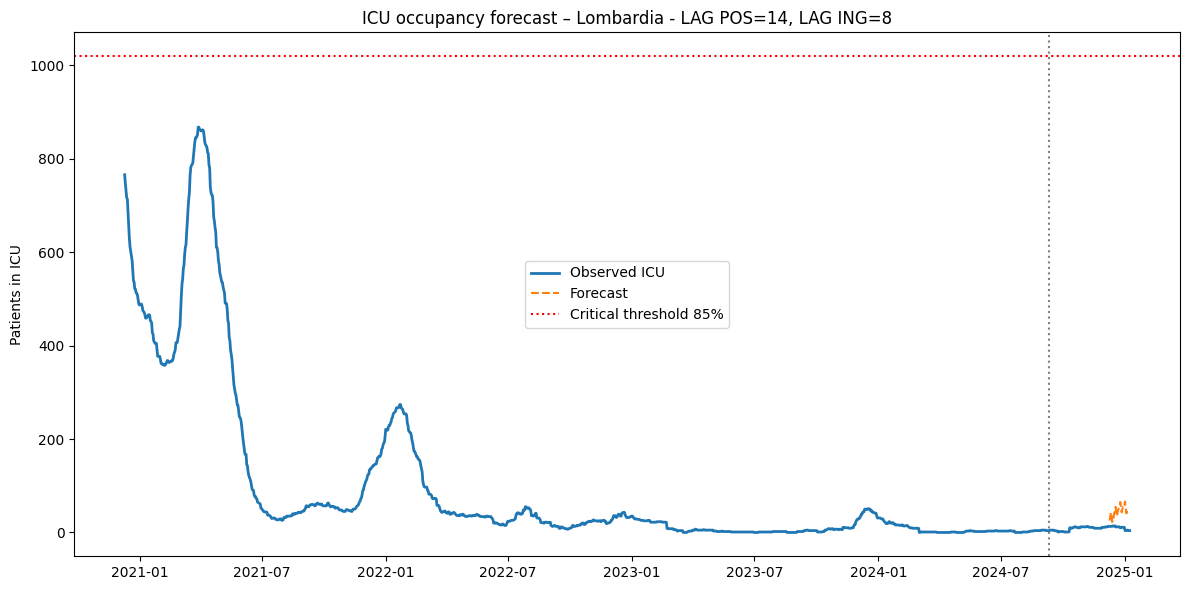

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(df["ds"], df["y"], label="Observed ICU", linewidth=2)
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", linestyle="--")
plt.axvline(test["ds"].min(), color="gray", linestyle=":")
# Soglia critica
plt.axhline((POSTI_TI*85)/100, color='red', linestyle=':', label='Critical threshold 85%')
plt.title(f"ICU occupancy forecast – {REGIONE} - LAG POS={LAG_POS}, LAG ING={LAG_ING}")
plt.ylabel("Patients in ICU")
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Intervalli di lag da testare
lag_pos_range = range(5, 16)   # es. da 5 a 15 giorni
lag_ing_range = range(3, 10)   # es. da 3 a 9 giorni

risultati = []

for lag_pos in lag_pos_range:
    for lag_ing in lag_ing_range:
        df_copy = df.copy()

        # Calcolo colonne lag
        df_copy["positivi_lag"] = df_copy["nuovi_positivi"].shift(lag_pos)
        df_copy["ingressi_lag"] = df_copy["ingressi_terapia_intensiva"].shift(lag_ing)
        df_copy["y"] = df_copy["y"].rolling(3, center=True).median().bfill()
        df_copy["cap"] = df_copy["cap"]
        df_copy["floor"] = 0
        df_copy["ds"] = df_copy["ds"]

        # Costruzione df_model
        df_model = df_copy[["ds", "y", "positivi_lag", "ingressi_lag", "cap", "floor"]].dropna()

        # Split: ultimi 30 giorni come test
        df_train = df_model[:-30]
        df_test = df_model[-30:]

        model = Prophet(growth="logistic", daily_seasonality=True, changepoint_prior_scale=0.3)
        model.add_regressor("positivi_lag")
        model.add_regressor("ingressi_lag")
        model.fit(df_train)

        # Previsione solo sul test set
        future = df_test[["ds", "positivi_lag", "ingressi_lag", "cap", "floor"]].copy()
        forecast = model.predict(future)

        # Calcolo MAE
        forecast_test = forecast[forecast["ds"].isin(df_test["ds"])]
        prev = forecast_test[["ds", "yhat"]].set_index("ds").join(
            df_test.set_index("ds")[["y"]], how="inner").dropna()

        errore = mean_absolute_error(prev["y"], prev["yhat"])

        risultati.append({
            "LAG_POS": lag_pos,
            "LAG_ING": lag_ing,
            "MAE": errore
        })
        
df_train[["y", "cap", "floor"]].head()

# Mostra risultati ordinati
df_risultati = pd.DataFrame(risultati).sort_values("MAE")
display(df_risultati.head(10))

# Trova combinazione con MAE minimo
migliore = df_risultati.iloc[0]
lag_pos = int(migliore["LAG_POS"])
lag_ing = int(migliore["LAG_ING"])
print(f"Miglior risultato trovato: LAG_POS={lag_pos}, LAG_ING={lag_ing}, MAE={migliore['MAE']:.2f}")

# Ricalcola il modello solo per la combinazione ottimale
df_copy = df.copy()
df_copy["positivi_lag"] = df_copy["nuovi_positivi"].shift(lag_pos)
df_copy["ingressi_lag"] = df_copy["ingressi_terapia_intensiva"].shift(lag_ing)
df_copy["y"] = df_copy["y"].rolling(3, center=True).median().bfill()
df_copy["cap"] = df_copy["cap"]
df_copy["floor"] = 0

df_model = df_copy[["ds", "y", "positivi_lag", "ingressi_lag", "cap", "floor"]].dropna()
df_train = df_model[:-30]
df_test = df_model[-30:]
model = Prophet(growth="logistic", daily_seasonality=True, changepoint_prior_scale=0.3)
model.add_regressor("positivi_lag")
model.add_regressor("ingressi_lag")
model.fit(df_train)

forecast_test = forecast[forecast["ds"].isin(df_test["ds"])]
prev = forecast_test[["ds", "yhat"]].set_index("ds").join(
    df_test.set_index("ds")[["y"]], how="inner").dropna()

# Stampa risultati
print(prev[["y", "yhat"]].head(10))
print("MAE ricalcolato:", mean_absolute_error(prev["y"], prev["yhat"]))

16:32:12 - cmdstanpy - INFO - Chain [1] start processing
16:32:14 - cmdstanpy - INFO - Chain [1] done processing
16:32:17 - cmdstanpy - INFO - Chain [1] start processing
16:32:19 - cmdstanpy - INFO - Chain [1] done processing
16:32:22 - cmdstanpy - INFO - Chain [1] start processing
16:32:23 - cmdstanpy - INFO - Chain [1] done processing
16:32:26 - cmdstanpy - INFO - Chain [1] start processing
16:32:28 - cmdstanpy - INFO - Chain [1] done processing
16:32:30 - cmdstanpy - INFO - Chain [1] start processing
16:32:32 - cmdstanpy - INFO - Chain [1] done processing
16:32:35 - cmdstanpy - INFO - Chain [1] start processing
16:32:36 - cmdstanpy - INFO - Chain [1] done processing
16:32:39 - cmdstanpy - INFO - Chain [1] start processing
16:32:41 - cmdstanpy - INFO - Chain [1] done processing
16:32:43 - cmdstanpy - INFO - Chain [1] start processing
16:32:45 - cmdstanpy - INFO - Chain [1] done processing
16:32:47 - cmdstanpy - INFO - Chain [1] start processing
16:32:49 - cmdstanpy - INFO - Chain [1]

,LAG_POS,LAG_ING,MAE
49,12,3,7.122213
68,14,8,16.992183
33,9,8,25.917813
45,11,6,28.017815
3,5,6,29.172216
0,5,3,29.368072
53,12,7,30.580539
67,14,7,30.588036
69,14,9,30.621793
5,5,8,30.630286


Miglior risultato trovato: LAG_POS=12, LAG_ING=3, MAE=7.12


16:37:36 - cmdstanpy - INFO - Chain [1] start processing
16:37:36 - cmdstanpy - INFO - Chain [1] done processing


                        y       yhat
ds                                  
2024-12-08 17:00:00  13.0  25.472935
2024-12-09 17:00:00  13.0  32.252253
2024-12-10 17:00:00  13.0  42.650165
2024-12-11 17:00:00  13.0  36.818486
2024-12-12 17:00:00  13.0  22.408215
2024-12-13 17:00:00  14.0  30.974820
2024-12-14 17:00:00  14.0  31.021928
2024-12-15 17:00:00  14.0  42.188392
2024-12-16 17:00:00  14.0  43.965806
2024-12-17 17:00:00  12.0  54.756477
MAE ricalcolato: 35.38797981026473
